# Week 5 - Assignment 5.1

In [56]:
# 5.1 - In the BRFSS (see “The lognormal Distribution” on page 55), 
#the distribution of heights is roughly normal with parameters 
#μ = 178 cm and σ=7.7 cm for men, and μ = 163cm and σ=7.3cm for women.
#In order to join Blue Man Group, you have to be male and between 
#5′10″ and 6′1″ tall. 
#What percentage of the US male population is in this range? 
#Hint: use scipy.stats.norm.cdf.

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)
        
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [4]:
import thinkstats2
import thinkplot
import numpy as np
import brfss
import scipy.stats

df = brfss.ReadBrfss() 

In [5]:
mu = 178
sigma = 7.7
dt = scipy.stats.norm(loc=mu, scale=sigma) 
dt.mean(), dt.std() 

(178.0, 7.7)

In [14]:
#How many people are between 5'10" and 6'1"
#5'10 = 177.8 cms, 6'1 = 185.4 cms
dt.cdf(177.8) , dt.cdf(185.4)

(0.48963902786483265, 0.8317337108107857)

In [15]:
dt.cdf(185.4) - dt.cdf(177.8)

0.3420946829459531

In [7]:
#What percentage of the US =-population is in this range?
dt.cdf(mu - sigma)
#mu-sigma is around 0.159. US male population within 
#the 5'10 to 6'1 range is around 16%

0.1586552539314574

# Week 5 - Assignment 5.2


In [9]:
#To get a feel for the Pareto distribution, 
#let’s see how different the world would be if the
#distribution of human height were Pareto. 
#With the parameters xm=1 m and α=1.7, we get a distribution 
#with a reasonable minimum, 1 m, and median, 1.5 m.
#Plot this distribution. 
# What is the mean human height in Pareto world? 
# What fraction of the population is shorter than the mean? 
# If there are 7 billion people in Pareto world,
# How many do we expect to be taller than 1 km? 
# How tall do we expect the tallest person to be?

In [10]:
scipy.stats.pareto.stats(1)

alpha = 1.7
min_ht = 1  # meter
med = 1.5

ht = scipy.stats.pareto(b=alpha, scale=min_ht)
ht.median()

1.5034066538560549

In [11]:
# What is the mean height in Pareto world?
ht.mean()

2.428571428571429

In [13]:
#What fraction of the population is shorter than the mean? 
ht.cdf(ht.mean())

0.778739697565288

In [18]:
# If there are 7 billion people in Pareto world,
# How many do we expect to be taller than 1 km?
# 1km = 1000m
1 - ht.cdf(1000)
# (1 - ht.cdf(1000))*7000000000 (7 billion)
(1 - ht.cdf(1000)) * 7e9 , ht.sf(1000) * 7e9

(55602.976430479954, 55602.97643069972)

In [64]:
#How tall do we expect the tallest person to be?
# One way to solve this is to search for a height that we
# expect one person out of 7 billion to exceed.
# It comes in at roughly 600 kilometers. 
# 600 Kms = 600000m
ht.sf(600000) * 7e9  

1.0525455861201714

In [21]:
# Solution

# Another way is to use `ppf`, which evaluates the 
#"percent point function", which is the inverse CDF. 
#So we can compute the height in meters that corresponds to
# the probability (1 - 1/7e9).

ht.ppf(1 - 1 / 7e9)

618349.6106759505

# Week 5 - Assignment 6.1

In [32]:
#The distribution of income is famously skewed to the right. 
#In this exercise, we’ll measure how strong that skew is.
#The Current Population Survey (CPS) is a joint effort of the 
#Bureau of Labor Statistics and the Census Bureau to study income 
#and related variables. Data collected in 2013 is
#available from the Census Burea’s website. 
#I downloaded hinc06.xls, which is an Excel
#spreadsheet with information about household income, and converted it to
#hinc06.csv, a CSV file you will find in the repository for this book. 
#You will also find hinc2.py, which reads this file and transforms the data.
#The dataset is in the form of a series of income ranges and the number of respondents
#who fell in each range. The lowest range includes respondents who reported annual
#household income “Under $5000.” The highest range includes respondents who made
#“$250,000 or more.”
#To estimate mean and other statistics from these data, we have to make some assump‐
#tions about the lower and upper bounds, and how the values are distributed in each
#range. hinc2.py provides InterpolateSample, which shows one way to model this data.
#It takes a DataFrame with a column, income, that contains the upper bound of each
#range, and freq, which contains the number of respondents in each frame.
#It also takes log_upper, which is an assumed upper bound on the highest range, ex‐
#pressed in log10 dollars. The default value, log_upper=6.0 represents the assumption
#that the largest income among the respondents is 106
#, or one million dollars.

In [22]:
import hinc 
import numpy as np

income_df = hinc.ReadData()

In [23]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [24]:
#76 | Chapter 6: Probability Density Functions
#www.it-ebooks.info
#InterpolateSample generates a pseudo-sample; that is, 
#a sample of household incomes that yields the same number 
#of respondents in each range as the actual data. 
#It assumes that incomes in each range are equally spaced on a log10 scale.

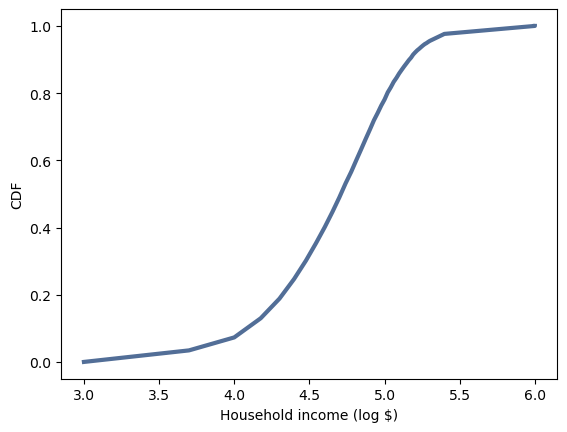

In [25]:
log_data = InterpolateSample(income_df, log_upper=6.0)
cdf_log = thinkstats2.Cdf(log_data)
thinkplot.Cdf(cdf_log)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

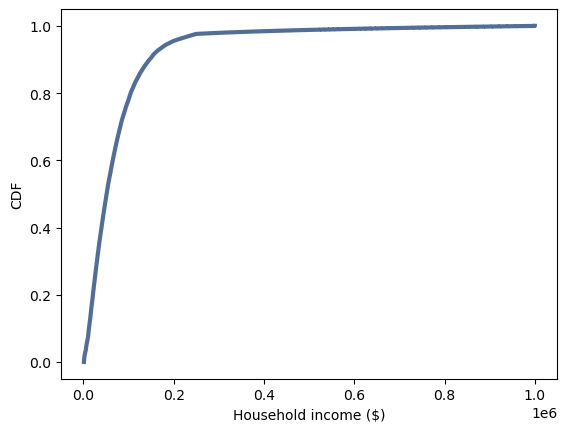

In [49]:
log_sample = np.power(10, log_data)
cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

In [39]:
def Median(dr):
    cdf = thinkstats2.Cdf(dr)
    return cdf.Value(0.5)

In [40]:
def Mean(dr):
    return RawMoment(dr, 1)

In [41]:
def RawMoment(dr, r):
    return sum(x**r for x in dr) / len(dr)

In [42]:
def CentralMoment(dr, r):
    mean = RawMoment(dr, 1)
    return sum((x - mean)**r for x in dr) / len(dr)

In [43]:
def Var(dr):
    return CentralMoment(dr, 2)

In [44]:
def PearsonMedianSkewness(dr):
    median = Median(dr)
    mean = RawMoment(dr, 1)
    var = CentralMoment(dr, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [45]:
def StandardizedMoment(dr, x):
    var = CentralMoment(dr, 2)
    std = np.sqrt(var)
    return CentralMoment(dr, x) / std**x

In [46]:
def Skewness(dr):
    return StandardizedMoment(dr, 3)

In [71]:
#Compute the median, mean, skewness and Pearson’s skewness of the resulting sample.
(Mean(log_sample),  Median(log_sample), Skewness(log_sample), 
PearsonMedianSkewness(log_sample))

(74278.70753118733, 51226.45447894046, 4.949920244429583, 0.7361258019141782)

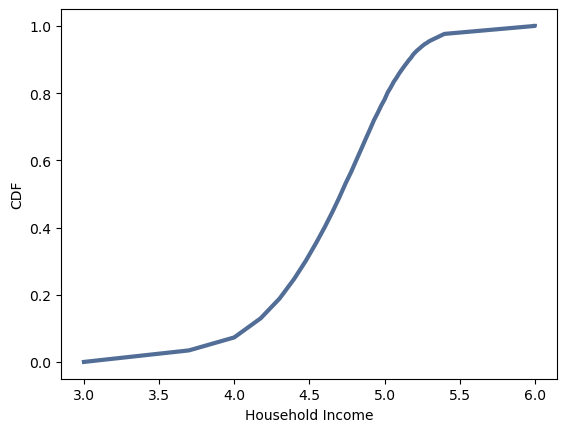

mean 74278.7075311872
std 93946.92996347835
median 51226.45447894046
skewness 4.949920244429583
pearson skewness 0.7361258019141782


(74278.7075311872, 51226.45447894046)

<Figure size 800x600 with 0 Axes>

In [69]:
# Solution goes here
import density as dn
  
thinkplot.Cdf(cdf_log)
thinkplot.Show(xlabel='Household Income',ylabel='CDF')
#dn.Summarize(log_data)
dn.Summarize(log_sample)

In [53]:
#What fraction of households reports a taxable income below the mean? 

cdf.Prob(Mean(log_sample))
# 66% of households reports a taxable income below the mean

0.660005879566872

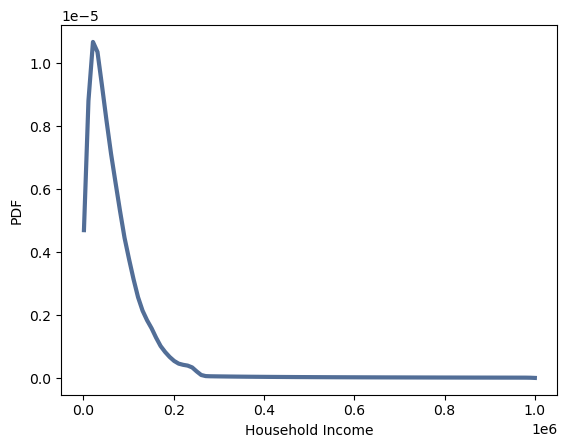

<Figure size 800x600 with 0 Axes>

In [55]:
#How do the results depend on the assumed upper bound? 

#All of this is based on an assumption that the highest income  
#is one million dollars, but that's certainly not correct. 
#What happens to the skew if the upper bound is 10 million?

pdf = thinkstats2.EstimatedPdf(log_sample)
thinkplot.Pdf(pdf)
thinkplot.Show(xlabel='Household Income',ylabel='PDF')

In [105]:
#Without better information about the top of this distribution, 
#we can't say much about the skewness of the distribution.